In [6]:
!wget https://raw.githubusercontent.com/nirajpandkar/flowers-classification-pytorch/master/cat_to_name.json
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
!mkdir data && tar -xvf flower_data.tar.gz -C data

Streaming output truncated to the last 5000 lines.
train/75/image_02161.jpg
train/75/image_02096.jpg
train/75/image_02181.jpg
train/75/image_02079.jpg
train/75/image_02129.jpg
train/75/image_02073.jpg
train/75/image_02162.jpg
train/75/image_02082.jpg
train/75/image_02098.jpg
train/75/image_02080.jpg
train/75/image_02150.jpg
train/75/image_02159.jpg
train/75/image_02158.jpg
train/75/image_02163.jpg
train/75/image_02160.jpg
train/75/image_02134.jpg
train/75/image_02101.jpg
train/75/image_02171.jpg
train/75/image_02117.jpg
train/75/image_02137.jpg
train/75/image_02136.jpg
train/75/image_02102.jpg
train/75/image_02146.jpg
train/75/image_02177.jpg
train/75/image_02110.jpg
train/75/image_02123.jpg
train/75/image_02105.jpg
train/75/image_02076.jpg
train/75/image_02116.jpg
train/75/image_02170.jpg
train/75/image_02132.jpg
train/75/image_02122.jpg
train/75/image_02090.jpg
train/75/image_02138.jpg
train/75/image_02097.jpg
train/75/image_02106.jpg
train/75/image_02084.jpg
train/75/image_02087.jpg

In [7]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
%matplotlib inline

In [8]:
data_dir = 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [9]:
import os,json

class FlowersDataset(ImageFolder):
    def __init__(self, root, transform):
        self.root = root
        super().__init__(self.root)
        self.files = [folder+"/"+fname for folder in os.listdir(root) for fname in os.listdir(root+"/"+folder) if fname.endswith('.jpg')]
        self.transform = transform
        with open('cat_to_name.json', 'r') as f:
          self.classes_idx = json.load(f)
        category_map = sorted(self.classes_idx.items(), key=lambda x: int(x[0]))
        self.classes = [cat[1] for cat in category_map]
    
    def __len__(self):
        return len(self.files)

In [10]:
import torchvision.transforms as T

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [11]:
train_dataset = FlowersDataset(train_dir, T.Compose([T.Resize(img_size), 
                                           T.Pad(8, padding_mode='reflect'),
                                           T.RandomCrop(img_size), 
                                           T.ToTensor(), 
                                           T.Normalize(*imagenet_stats)]))
print(train_dataset.classes)
print(len(train_dataset.classes))

['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia', 'cau

In [12]:
validation_dataset = FlowersDataset(valid_dir, T.Compose([T.Resize(img_size), 
                                           T.Pad(8, padding_mode='reflect'),
                                           T.RandomCrop(img_size), 
                                           T.ToTensor(), 
                                           T.Normalize(*imagenet_stats)]))

test_dataset = FlowersDataset(test_dir, T.Compose([T.Resize(img_size), 
                                           T.Pad(8, padding_mode='reflect'),
                                           T.RandomCrop(img_size), 
                                           T.ToTensor(), 
                                           T.Normalize(*imagenet_stats)]))

In [13]:
batch_size = 256

train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(validation_dataset, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
from torchvision.utils import make_grid

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [15]:
show_batch(train_dl)

Output hidden; open in https://colab.research.google.com to view.

In [16]:
def show_example(img, label,dataset):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  pink primrose (0)


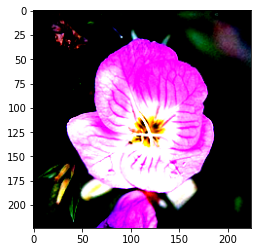

In [17]:
show_example(*train_dataset[0],train_dataset)

Label:  hard-leaved pocket orchid (1)


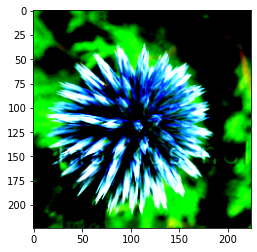

In [18]:
show_example(*validation_dataset[10],validation_dataset)

In [19]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [20]:
from torchvision import models

class FlowersModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [26]:
model = FlowersModel(len(train_dataset.classes))
to_device(model, device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

FlowersModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [30]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[{'val_loss': 4.77060604095459, 'val_acc': 0.00815078616142273}]

In [31]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [32]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00146, train_loss: 1.6390, val_loss: 1.7408, val_acc: 0.5881


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00430, train_loss: 0.5778, val_loss: 20.8579, val_acc: 0.0303


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00756, train_loss: 1.2719, val_loss: 8.4164, val_acc: 0.1615


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00971, train_loss: 1.2057, val_loss: 6.8022, val_acc: 0.2270


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00994, train_loss: 0.7901, val_loss: 3.1221, val_acc: 0.4175


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00950, train_loss: 0.5501, val_loss: 2.5335, val_acc: 0.5247


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00867, train_loss: 0.3806, val_loss: 1.3832, val_acc: 0.6367


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00750, train_loss: 0.2669, val_loss: 0.8034, val_acc: 0.7831


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00611, train_loss: 0.1574, val_loss: 0.7946, val_acc: 0.7980


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00463, train_loss: 0.1096, val_loss: 0.7110, val_acc: 0.8105


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [10],last_lr: 0.00317, train_loss: 0.0521, val_loss: 0.3653, val_acc: 0.9142


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [11],last_lr: 0.00188, train_loss: 0.0265, val_loss: 0.2888, val_acc: 0.9321


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [12],last_lr: 0.00087, train_loss: 0.0124, val_loss: 0.2475, val_acc: 0.9400


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [13],last_lr: 0.00022, train_loss: 0.0070, val_loss: 0.2693, val_acc: 0.9472


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [14],last_lr: 0.00000, train_loss: 0.0059, val_loss: 0.2503, val_acc: 0.9370
CPU times: user 2min 19s, sys: 1min 55s, total: 4min 15s
Wall time: 16min 34s


In [33]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

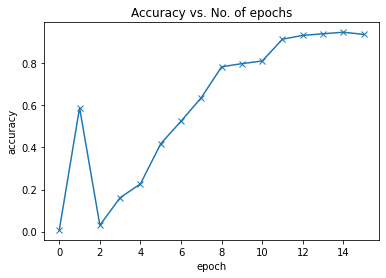

In [34]:
plot_accuracies(history)

In [35]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

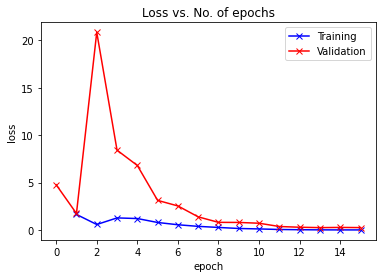

In [36]:
plot_losses(history)